- Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
- При желании можете воспользоваться своим временным рядом — работа, Kaggle и т. д.
- Посмотрите на результаты с разными длинами окон.
- Обязательно визуализируйте результаты аналогично материалу с занятия.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Будем смотреть, как изменялась цена на золото между августом 2021 и сентябрём 2022

In [31]:
timeseries = pd.read_csv('Gold Price.csv', index_col=0)['Price']['2020-08-04':'2022-08-04']

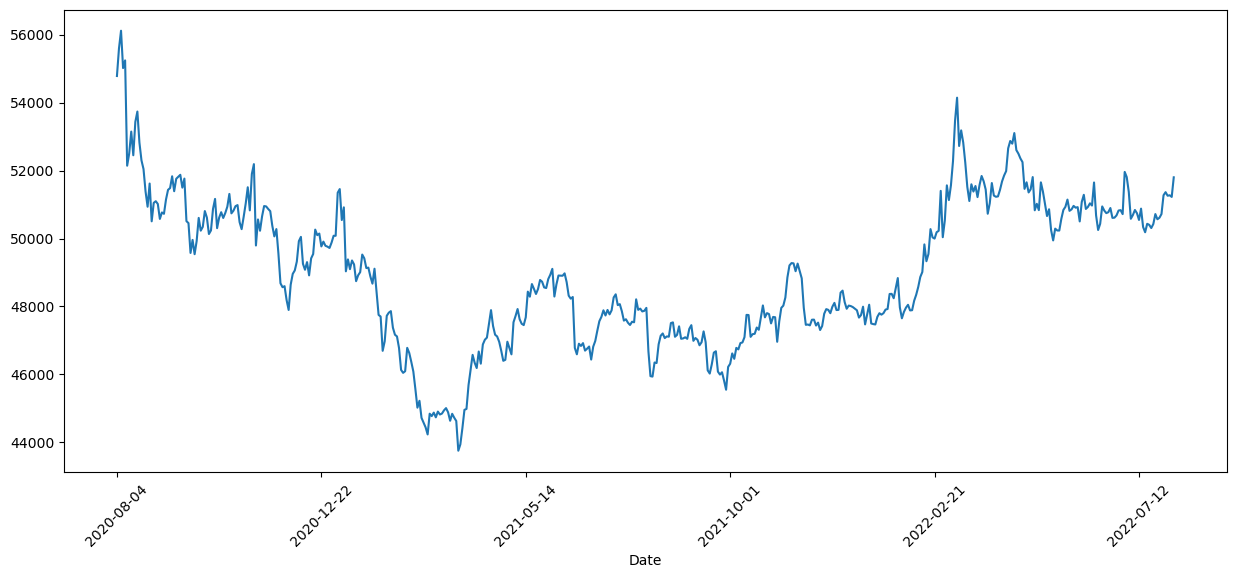

In [32]:
plt.figure(figsize=(15, 6))
timeseries.plot()
plt.xticks(rotation=45)
plt.show()

In [3]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

# Из-за больших значений цены удобнее будет смотреть на графики отдельно. 
- Группируем по принципу:
    - F0 и оригинал в один график
    - Все остальные в другой (потому что значения лагов более 1 имеют предел около нуля)

In [40]:
def plot_SSA_decomposition(model, L):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
    
    orig_TS = model.orig_TS
    df = model.components_to_df()

    ax1.plot(df.index, orig_TS, label='Original', alpha=0.4)
    ax1.plot(df.index, df['F0'], label='F0')
    
    without_F0 = df.drop('F0', axis=1)
    ax2.plot(df.index, without_F0, label=[i for i in without_F0.columns])
    
    plt.xticks(orig_TS.index[::21], rotation=45)
    fig.suptitle(f"Component Groupings for Time Series, $L={L}$")
    plt.xlabel("$t$")
    plt.ylabel(r"$\tilde{F}_i(t)$")
    ax1.legend()
    ax2.legend()
    plt.show()

# Lets see at L=2

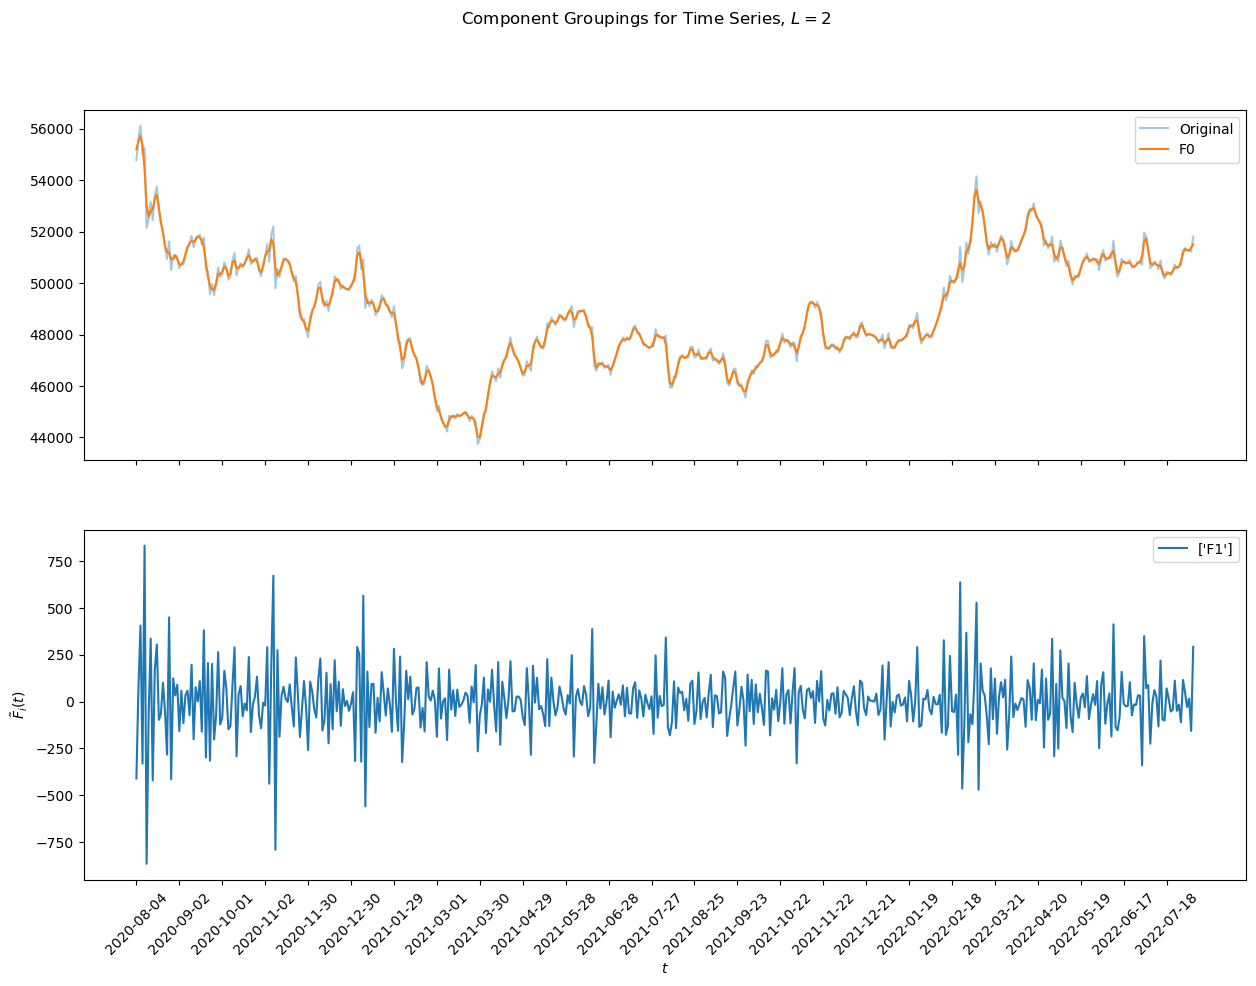

In [41]:
SSA_L2 = SSA(timeseries, 2)

plot_SSA_decomposition(SSA_L2, 2)

# L = 5

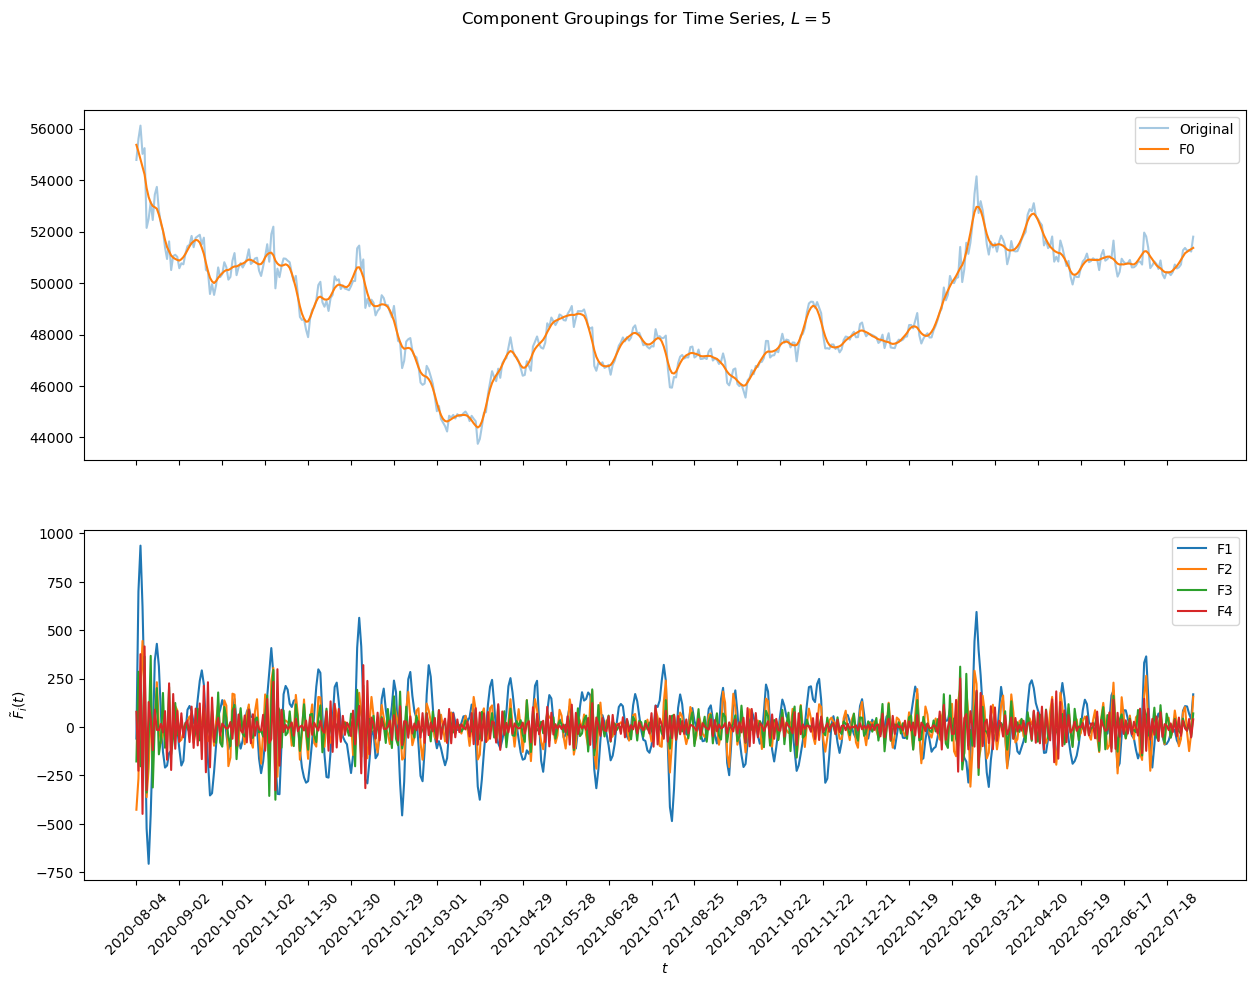

In [42]:
SSA_L5 = SSA(timeseries, 5)

plot_SSA_decomposition(SSA_L5, 5)

# L=10, но уже посерьёзнее

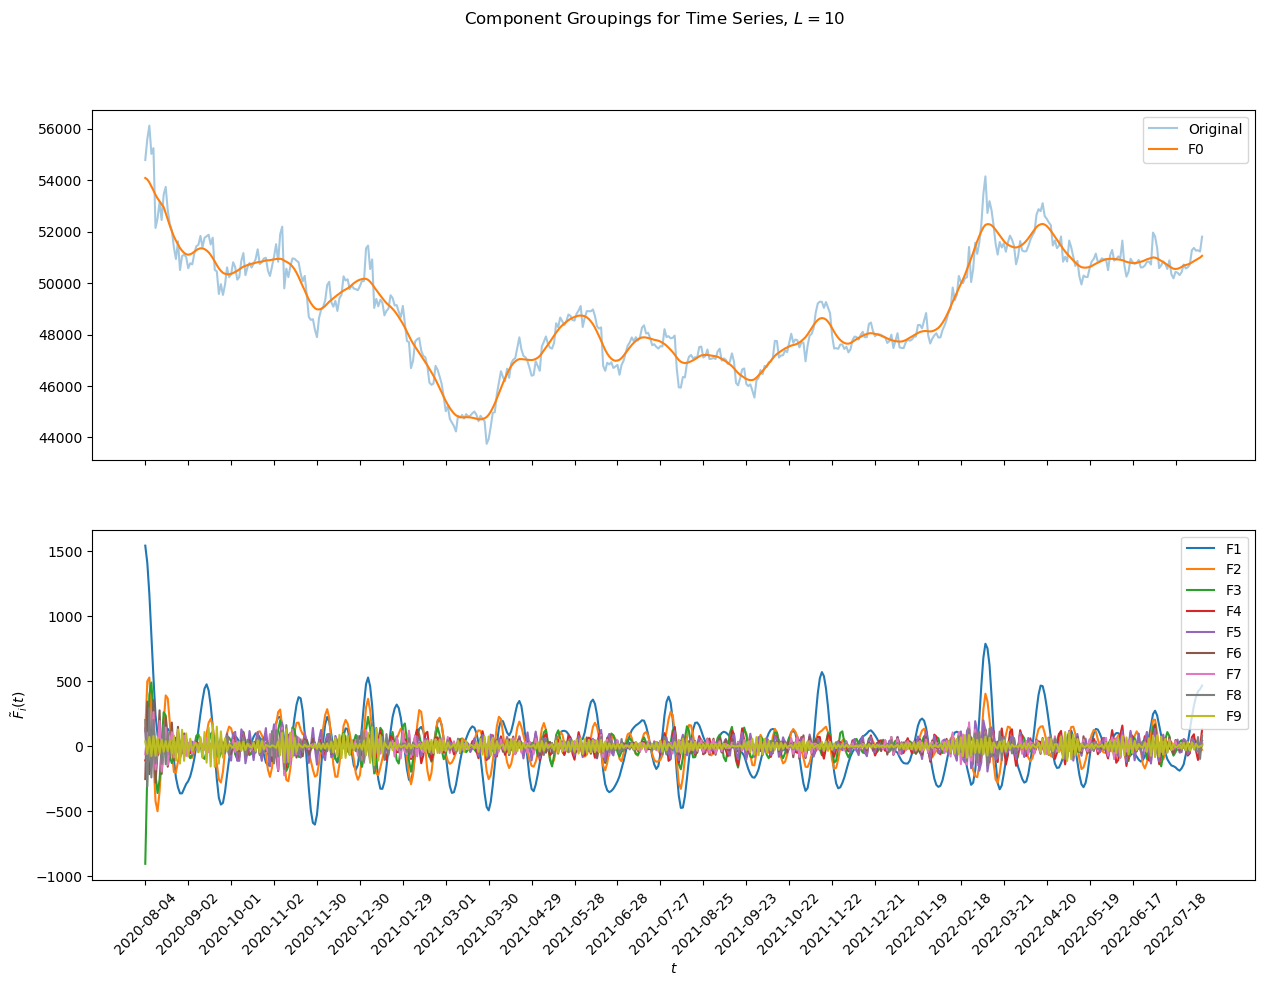

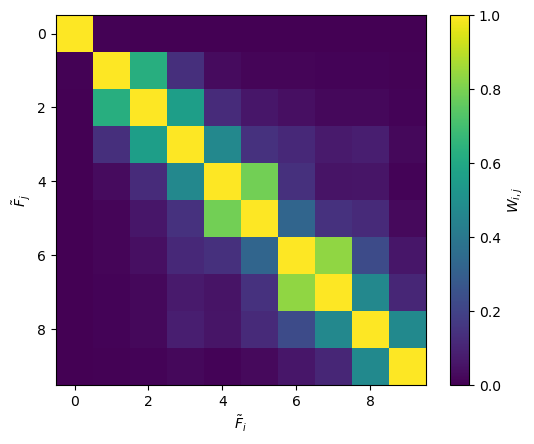

In [43]:
SSA_L10 = SSA(timeseries, 10)

plot_SSA_decomposition(SSA_L10, 10)
SSA_L10.plot_wcorr()

- Наверное, пока рано говорить о паттернах

# L=21

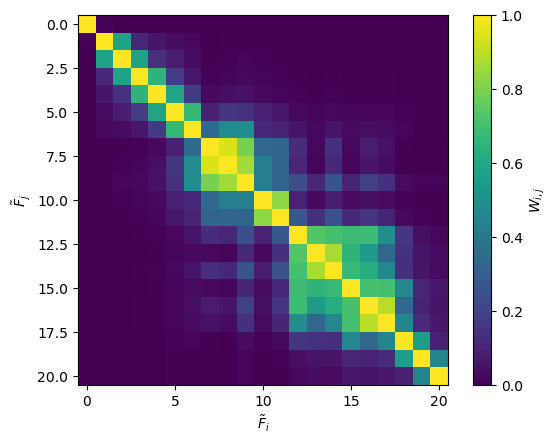

In [44]:
SSA_L21 = SSA(timeseries, 21)

SSA_L21.plot_wcorr()

- Тут уже что-то более-менее видно. Попробуем допустить, скажем:
    - Какой-то интересный паттерн между 2 и 5
    - После 7 идёт что-то непонятное. Поступим консервативно и допустим, что всё дальше - шум

# L = 247

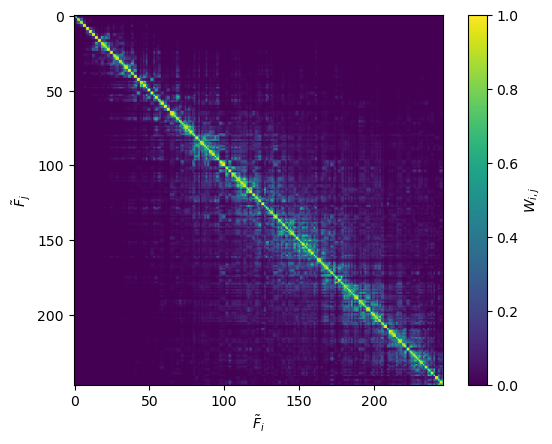

In [90]:
SSA_L247 = SSA(timeseries, 247)

SSA_L247.plot_wcorr()

- посмотрим внимательнее, что у нас там около 20

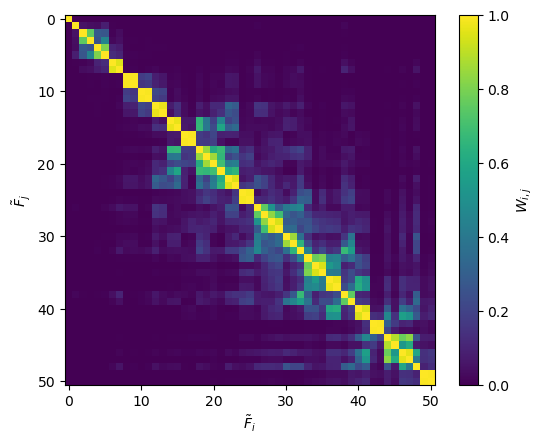

In [94]:
SSA_L247.plot_wcorr(min=0, max=50)

- Также можно увидеть интересный перегиб между 90 и 100. Зазумим

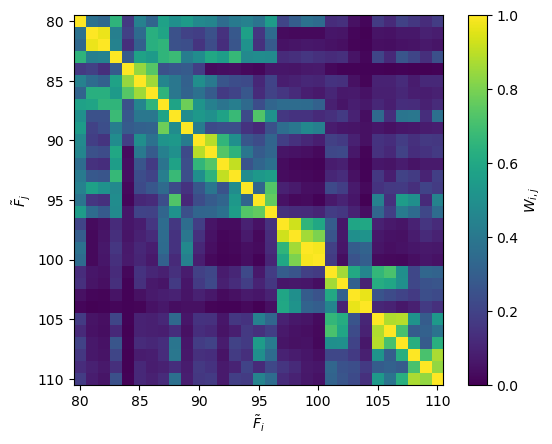

In [97]:
SSA_L247.plot_wcorr(min=80, max=110)

- Попробуем поставить наш перегиб как разделитель

# Реконструктим

1) Во-первых, почему выбраны именно такие окна:
    1) L=2 - просто, чтобы посмотреть, как сработает ССА с минимальным окном
    2) L=5, поскольку график с шагом измерения 1 день, но при этом измерения сделаны в 5-дневной неделе. Видимо, наблюдения велись только в те дни, когда работала биржа
    3) L=21, та же логика, что и в Б), только теперь берём месячное окно - в месяце в среднем 21 рабочий день
    4) L=247- в среднем, рабочих дней в году

- В соответствие с нашими ранними заметками будем реконструктить графики, беря окна с интервалами:
    - между 2 и 5 определённо что-то есть - [2, 5]
    - Интересный game-changing перегиб на 96 - [6, 96]
    - Поступим консервативно и скажем, что после 97 идёт шум

In [161]:
 def merge_F_plot(model, slice_):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
    
    orig_TS = model.orig_TS
    df = model.components_to_df()

    ax1.plot(df.index, orig_TS, label='Original', alpha=0.4)
    
    SSA_L247.reconstruct(slice_).plot(label=f'{slice_}')
    
    plt.xticks(orig_TS.index[::21], rotation=45)

    plt.xlabel("$t$")
    plt.ylabel(r"$\tilde{F}_i(t)$")
    ax1.legend()
    ax2.legend()
    plt.show()

<Axes: xlabel='Date'>

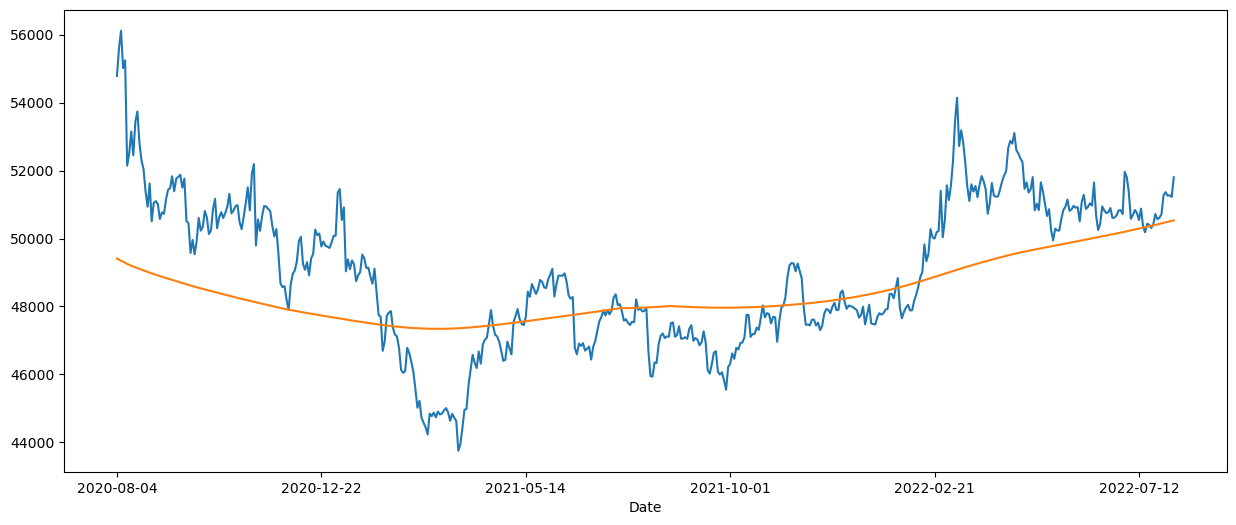

In [159]:
plt.figure(figsize=(15,6))
timeseries.plot()
SSA_L247.reconstruct(0).plot()

- Что-то типа тренда вышло :/

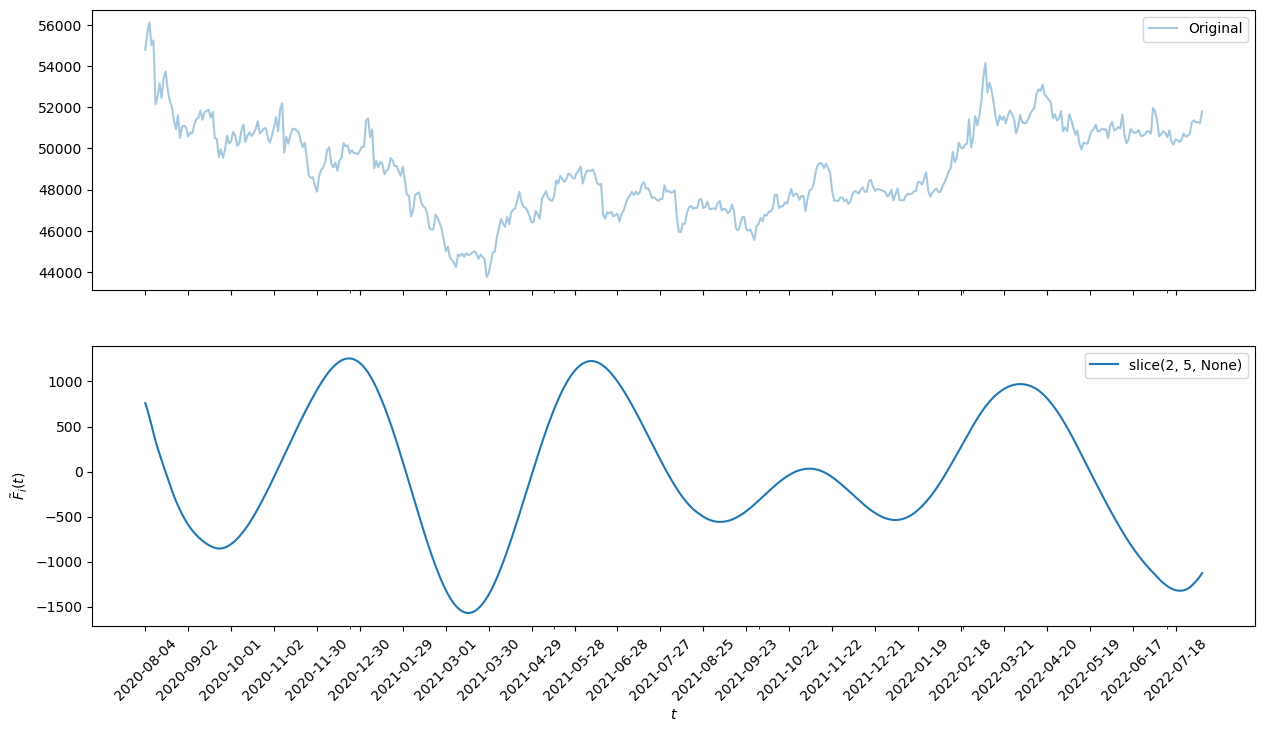

In [162]:
merge_F_plot(SSA_L247, slice(2, 5))

- Круто, поймали основные флуктуации
____
Пробуем дальше. Посмотрим, что у нас между 6 и 96

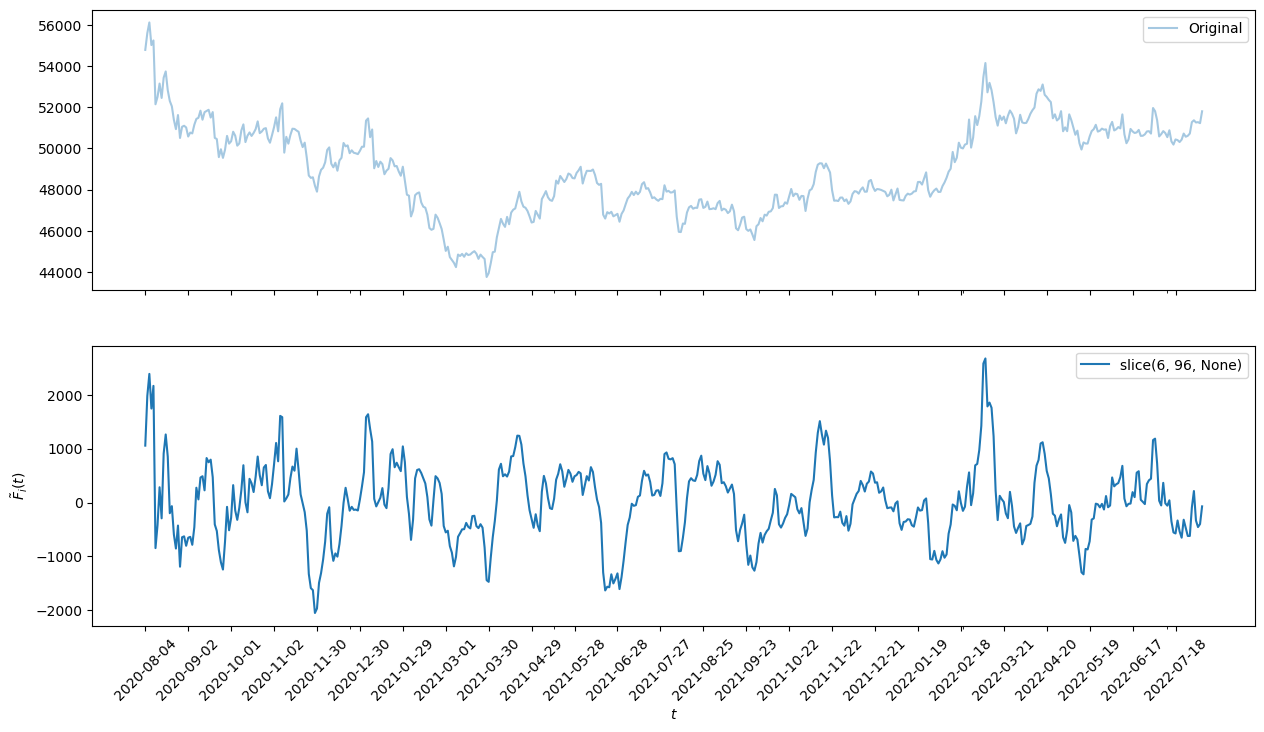

In [164]:
merge_F_plot(SSA_L247, slice(6, 96))

- Это ли наша искомая функция?

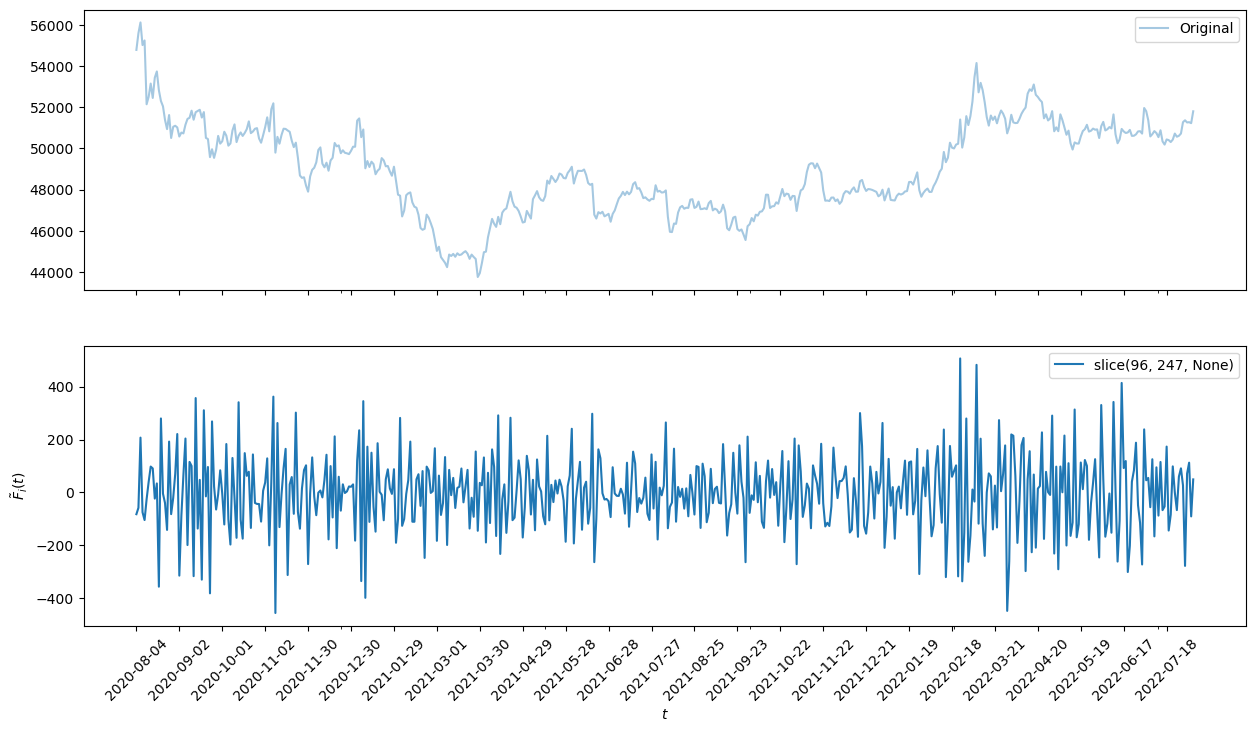

In [165]:
merge_F_plot(SSA_L247, slice(96, 247))

- а вот это уже, видимо, шум

<Axes: xlabel='Date'>

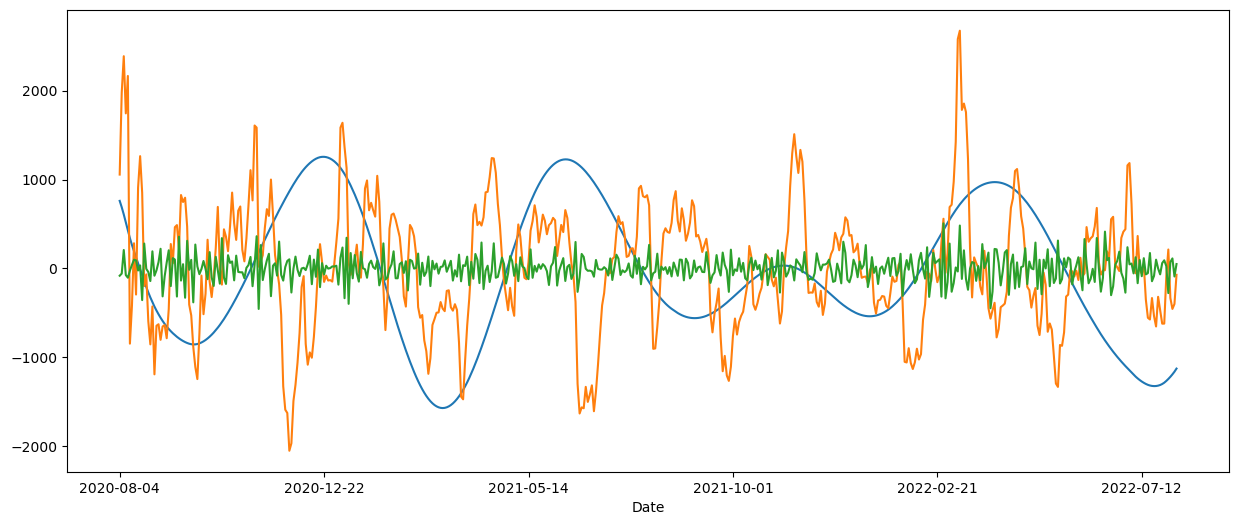

In [166]:
plt.figure(figsize=(15,6))
SSA_L247.reconstruct(slice(2, 5)).plot()
SSA_L247.reconstruct(slice(6, 96)).plot()
SSA_L247.reconstruct(slice(96, 247)).plot()

# Выводы

- По теории:
    - Золото, в принципе, очень волатильный и зависимый от геополитики, новостей и всяких кризисов актив. Из этого следует:
        - Вряд ли можно поймать какой-то чёткий тренд по активу
        - Более логично было бы смотреть не по всему беспросветно-кризисному периоду 19-22, а по отдельным периодам: корона; затишье после бури (межкризисье); после февраля 22-го
- По рядам:
    - Мы точно нашли некое подобие тренда (в смысле общую тенденцию развития) и шум.
    - Насчёт остальных компонентов я не уверен, но кажется, что тут есть некое подобие цикличности в разрезе примено 7-8 месяцев, судя по графику
    - Для просмотра сезонности надо опускаться на уровень ниже - смотреть в разрезе месяца, полугода по отдельным периодам и т.д.